We all know about the fact that cars depreciate. We also think that some class of cars (saloons vs SUV) and some brands perform better in retaining value.

I also know of these myths. But how true are they? I have 3 questions I want to answer:
1. Do SUVs depreciate less than saloon/estates?
2. Does doing less milage reduce depreciation?
3. Does having a car with a bigger engine reduce depreciation?
3. Do some brands depreciate less than others?

To answer these questions I have scraped data from a lot of car adds of the internet. Let's have a look at what it says

In [122]:
import pandas as pd
import numpy as np
import Database as db
import matplotlib.pyplot as plt
import seaborn as sns

connection = db.create_server_connection("localhost", "root", "Englezu1992!", "CarData_BMW")

df = pd.read_sql('SELECT * FROM BMW', con=connection)

df.head()

Connection to database CarData_BMW established.


,id,price,model,year,body,milage,engine_size,engine_power,transmission,fuel_type,owners,ultra_low_emissions_zone,service_history,first_year_road_tax,full_manufacturer_warranty,unexpected_value
0,1,9995,5 Series,2015,saloon,126000,2.0,190,automatic,diesel,1,1,full dealership history,0,0,ok
1,2,14450,5 Series,2016,saloon,52761,2.0,190,automatic,diesel,100,1,unlisted,0,0,ok
2,3,11880,5 Series,2015,saloon,75000,2.0,190,automatic,diesel,100,1,unlisted,0,0,ok
3,4,10950,5 Series,2015,saloon,81000,2.0,190,automatic,diesel,3,1,unlisted,0,0,ok
4,5,13495,5 Series,2015,saloon,54758,2.0,190,automatic,diesel,2,1,full dealership history,0,0,ok


First I want to limit the model at which I am looking. I don't want to look at cars which have a high prestige element to their pricing. The list of allowed models I have chosen is fully subjective.

I am also eliminating engines bigger than 4.4. L because there are not enough cars (17) to extract any meaningfull trend.

In [123]:
accepted_model_list = ['5 Series', '4 Series Gran Coupe', '4 Series',
       '3 Series', 'Z4', '1 Series',
       'X6', 'X5', 'X4', 'X3', 'X1',
       '7 Series', '2 Series Gran Tourer',
       '2 Series Active Tourer', '2 Series']
df = df.loc[df['model'].isin(accepted_model_list)]
df = df.loc[df['engine_size'] < 6]

df['model'].unique()

array(['5 Series', '4 Series Gran Coupe', '4 Series', '3 Series', 'Z4',
       '1 Series', 'X6', 'X5', 'X4', 'X3', 'X1', '7 Series',
       '2 Series Gran Tourer', '2 Series Active Tourer', '2 Series'],
      dtype=object)

Next I want to fix a mistake I made when scraping. I have used some numbers instead of NaN to mark missing data and forgot to make the scraped check for when a car is brand new. But this can be easily identified in the data.

In [124]:
for idx, row in df.iterrows():
    if df.loc[idx,'milage'] == 1000000 and df.loc[idx,'year'] == 0 and df.loc[idx,'owners'] == 100:
        df.loc[idx,'milage'] = 0
        df.loc[idx,'year'] = 2022
        df.loc[idx,'owners'] = 0

Now let's correct some things I know are wrong with the data.
1. One person added an extra 0 to the price of their X3
2. A small enough number of people did not specify the vehicle milage so that we can drop their adds.
3. Some people are claiming an improbably large number of miles done in just 3.5 years of ownership.
4. One guy added too many 9s to the price of their 5 Series
5. Another guy added too many zeros to the price of his 5 Series
6. One guy advertised an alpina B5 as a normal 5 series. I am interested only in cars that are valued for their utility mostly, not for their luxury.

In [125]:
#1
wrong_price_index = df.index[df['price'] == df['price'].max()][0]
df.loc[wrong_price_index,'price'] = int(df['price'].max()/10)
#2 & 3
df = df.loc[df['milage'] < 300000]
#4
wrong_price_index = df.index[(df['body'] == 'saloon') & (df['price'] == 134999)][0]
df.loc[wrong_price_index,'price'] = 13499
#5
wrong_price_index = df.index[(df['body'] == 'saloon') & (df['price'] == 117400)][0]
df.loc[wrong_price_index,'price'] = 11740
#6
wrong_price_index = df.index[(df['body'] == 'estate') & (df['price'] ==  103720)][0]
df = df.drop(wrong_price_index)

In [126]:
df['body'].isna().sum()

0

First let's have a look at how model and body influence age induced depreciation

In [127]:
list_of_years = np.sort(df['year'].unique())
list_of_bodies = np.delete(df['body'].unique(),np.where(df['body'].unique()=='unlisted'))

age_depreciation_individual_year = pd.DataFrame(columns = ['Body','Year','Age depreciation'])

counter = 0

for body in list_of_bodies:
    for year in list_of_years:
        if year != 2022:
            future_year_mean = df.loc[(df['year'] == list_of_years[np.where(list_of_years == year)[0][0] + 1]) & (df['body'] == body)]['price'].mean()
            current_year_mean = df.loc[(df['year'] == year) & (df['body'] == body)]['price'].mean()
            difference = (future_year_mean - current_year_mean) / future_year_mean * 100
            if pd.notna(difference):
                age_depreciation_individual_year.loc[counter, 'Body'] = body
                age_depreciation_individual_year.loc[counter, 'Year'] = year
                age_depreciation_individual_year.loc[counter, 'Age depreciation'] = difference
                counter += 1
        else:
            next

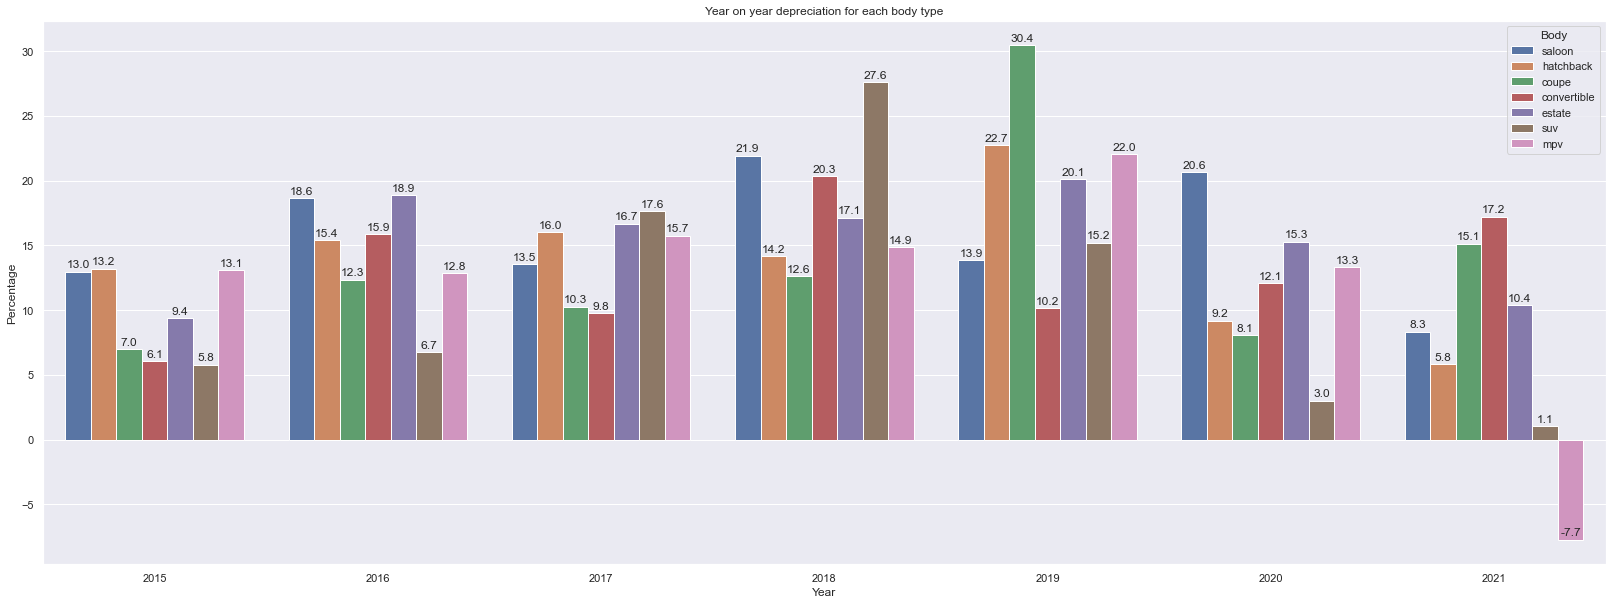

In [128]:
ax = sns.barplot(x = 'Year', y = 'Age depreciation', hue = 'Body', data = age_depreciation_individual_year)
sns.set(rc={'figure.figsize':(28,10)})
ax.set(title = 'Year on year depreciation for each body type', ylabel = 'Percentage')

for p in ax.patches:
    height = p.get_height()
    if pd.notna(height):
        ax.text(x = p.get_x()+(p.get_width()/2), y = height + 0.3, s = '{:.1f}'.format(height), ha = 'center')

In [129]:
list_of_years = np.sort(df['year'].unique())
list_of_bodies = np.delete(df['body'].unique(),np.where(df['body'].unique()=='unlisted'))
list_of_models = df['model'].unique()

age_depreciation_all_years = pd.DataFrame(columns = ['Model', 'Body', 'Age depreciation'])

counter = 0

for model in list_of_models:
    for body in list_of_bodies:
        original_value = df.loc[(df['model'] == model) & (df['year'] == 2021) & (df['body'] == body)]['price'].mean()
        depreciated_value = df.loc[(df['model'] == model) & (df['year'] == 2015) & (df['body'] == body)]['price'].mean()
        depreciation_percentage = (original_value - depreciated_value) / original_value * 100
        if pd.notna(depreciation_percentage):
            age_depreciation_all_years.loc[counter, 'Model'] = model
            age_depreciation_all_years.loc[counter, 'Body'] = body
            age_depreciation_all_years.loc[counter, 'Age depreciation'] = depreciation_percentage
            counter += 1

age_depreciation_all_years.head(20)

,Model,Body,Age depreciation
0,5 Series,saloon,70.07755
1,5 Series,estate,72.142229
2,4 Series Gran Coupe,hatchback,57.543302
3,4 Series,coupe,62.499296
4,3 Series,saloon,65.306879
5,3 Series,estate,62.865951
6,Z4,convertible,55.144294
7,1 Series,hatchback,65.610253
8,X6,suv,57.038618
9,X5,suv,58.071597


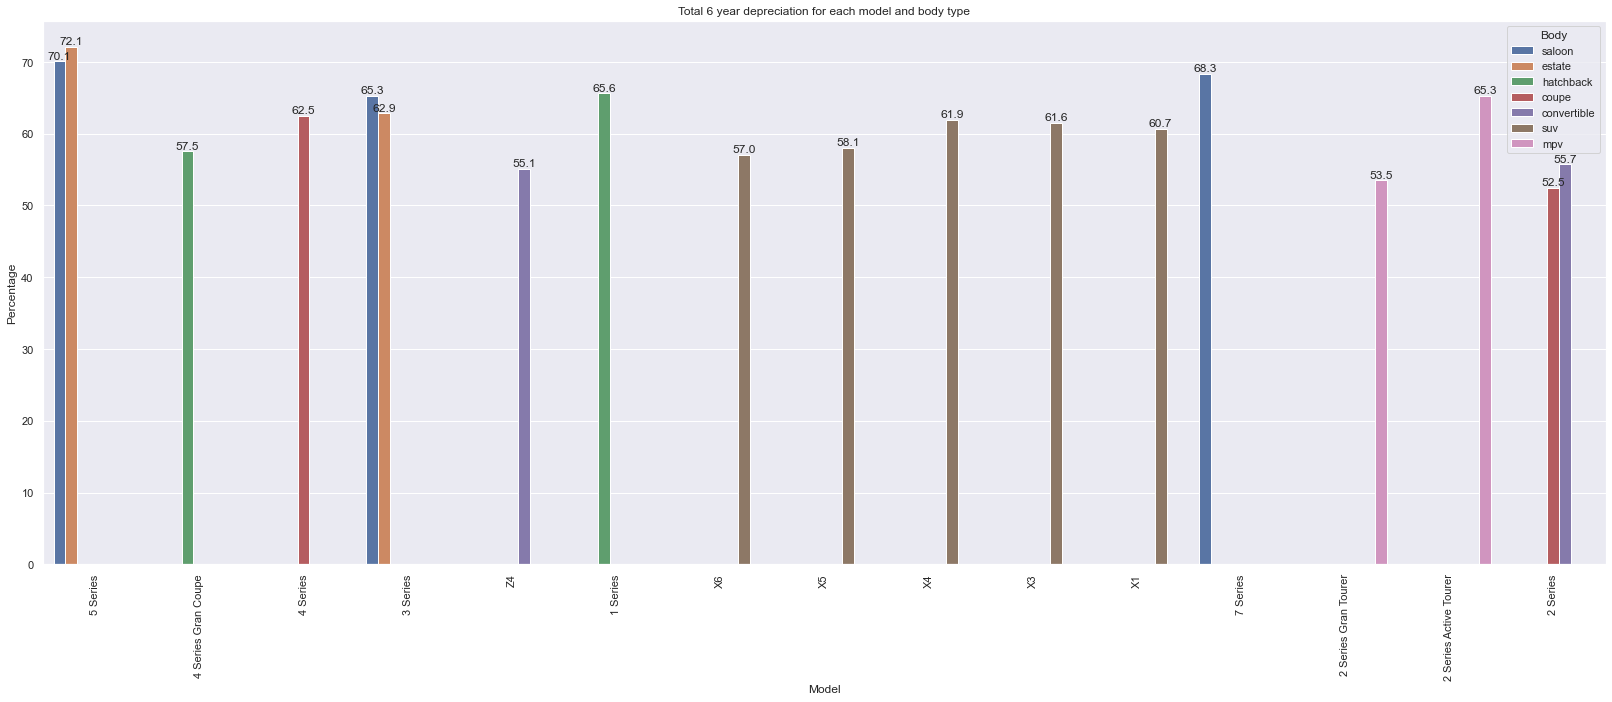

In [130]:
ax = sns.barplot(x = 'Model', y = 'Age depreciation', hue = 'Body', data = age_depreciation_all_years)
sns.set(rc={'figure.figsize':(28,10)})
ax.set(title = 'Total 6 year depreciation for each model and body type', ylabel = 'Percentage')

for p in ax.patches:
    height = p.get_height()
    if pd.notna(height):
        ax.text(x = p.get_x()+(p.get_width()/2), y = height + 0.3, s = '{:.1f}'.format(height), ha = 'center')

locs, labels = plt.xticks()
plt.setp(labels, rotation=90);

Now let's have a look at how model and body influence model induced price difference.

In [131]:
list_of_years = np.sort(df['year'].unique())
list_of_bodies = np.delete(df['body'].unique(),np.where(df['body'].unique()=='unlisted'))

milage_depreciation_individual_year = pd.DataFrame(columns = ['Body','Year','Milage induced price difference'])

counter = 0

for body in list_of_bodies:
    for year in list_of_years:
        if year != 2022:
            filtered_df = df.loc[(df['body'] == body) & (df['year'] == year)]
            low_milage_mean = filtered_df.loc[filtered_df['milage'] < filtered_df['milage'].mean()]['price'].mean()
            high_milage_mean = filtered_df.loc[filtered_df['milage'] > filtered_df['milage'].mean()]['price'].mean()
            percentage_difference = (low_milage_mean - high_milage_mean) / low_milage_mean * 100
            if pd.notna(percentage_difference):
                milage_depreciation_individual_year.loc[counter, 'Body'] = body
                milage_depreciation_individual_year.loc[counter, 'Year'] = year
                milage_depreciation_individual_year.loc[counter, 'Milage induced price difference'] = percentage_difference
                counter += 1
        else:
            next

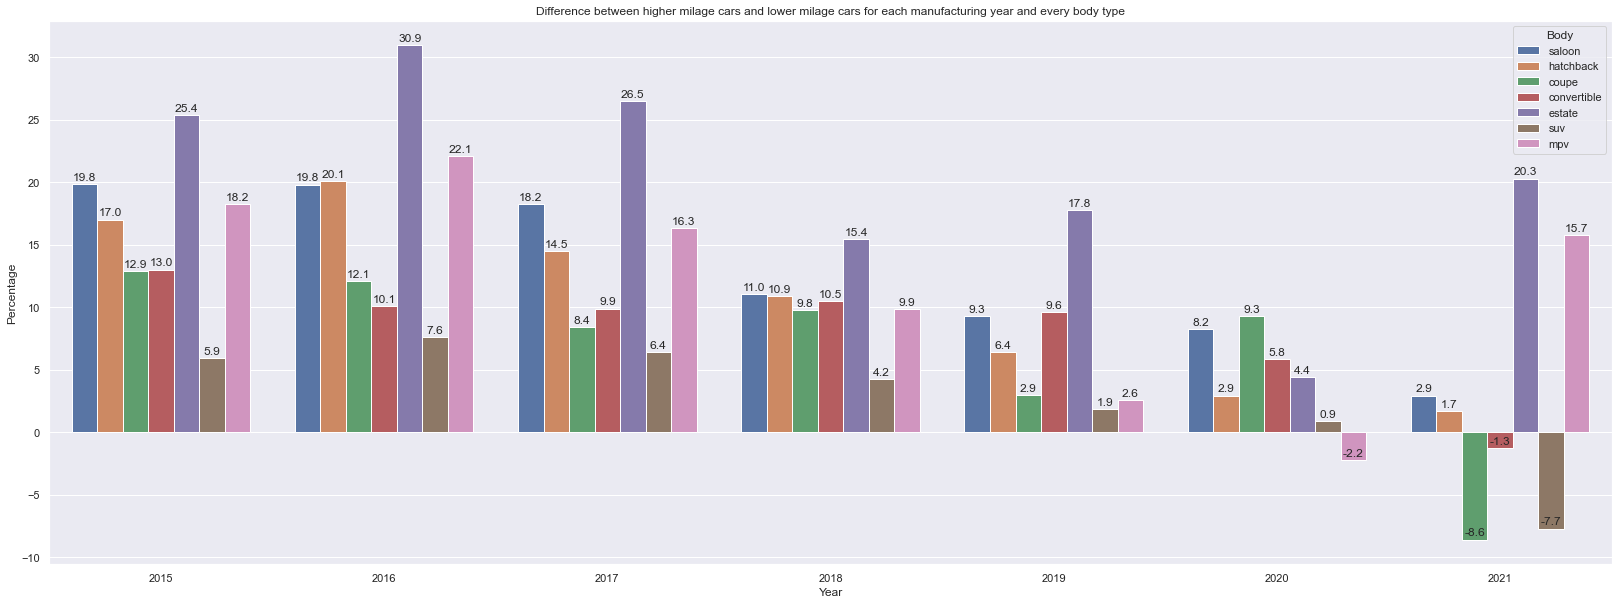

In [132]:
ax = sns.barplot(x = 'Year', y = 'Milage induced price difference', hue = 'Body', data = milage_depreciation_individual_year)
sns.set(rc={'figure.figsize':(28,10)})
ax.set(title = 'Difference between higher milage cars and lower milage cars for each manufacturing year and every body type', ylabel = 'Percentage')

for p in ax.patches:
    height = p.get_height()
    if pd.notna(height):
        ax.text(x = p.get_x()+(p.get_width()/2), y = height + 0.3, s = '{:.1f}'.format(height), ha = 'center')

In [133]:
list_of_years = np.sort(df['year'].unique())
list_of_bodies = np.delete(df['body'].unique(),np.where(df['body'].unique()=='unlisted'))
list_of_models = df['model'].unique()

milage_depreciation_all_years = pd.DataFrame(columns = ['Model', 'Body','Milage induced price difference'])

counter = 0

for model in list_of_models:
    for body in list_of_bodies:
        acumulator = 0
        corrector = 0
        for year in list_of_years:
            filtered_df = df.loc[(df['model'] == model) & (df['body'] == body) & (df['year'] == year)]
            low_milage_mean = filtered_df.loc[filtered_df['milage'] < filtered_df['milage'].mean()]['price'].mean()
            high_milage_mean = filtered_df.loc[filtered_df['milage'] > filtered_df['milage'].mean()]['price'].mean()
            if pd.notna(low_milage_mean) and pd.notna(high_milage_mean):
                percentage_difference = (low_milage_mean - high_milage_mean) / low_milage_mean * 100
                acumulator += percentage_difference
            else:
                corrector += 1
        if (len(list_of_years) - corrector) > 0:
            percentage_difference = acumulator / (len(list_of_years) - corrector)
            milage_depreciation_all_years.loc[counter, 'Model'] = model
            milage_depreciation_all_years.loc[counter, 'Body'] = body
            milage_depreciation_all_years.loc[counter, 'Milage induced price difference'] = percentage_difference
            counter += 1
        elif (len(list_of_years) - corrector) < 0:
            print('Acumulator: ', acumulator,', Corrector: ', corrector)
        else:
            pass

milage_depreciation_all_years.head(20)

,Model,Body,Milage induced price difference
0,5 Series,saloon,11.194532
1,5 Series,estate,16.623714
2,4 Series Gran Coupe,hatchback,15.428676
3,4 Series,coupe,7.812462
4,4 Series,convertible,9.106127
5,3 Series,saloon,12.841723
6,3 Series,hatchback,-0.301003
7,3 Series,estate,20.381335
8,Z4,convertible,6.316909
9,1 Series,hatchback,11.056736


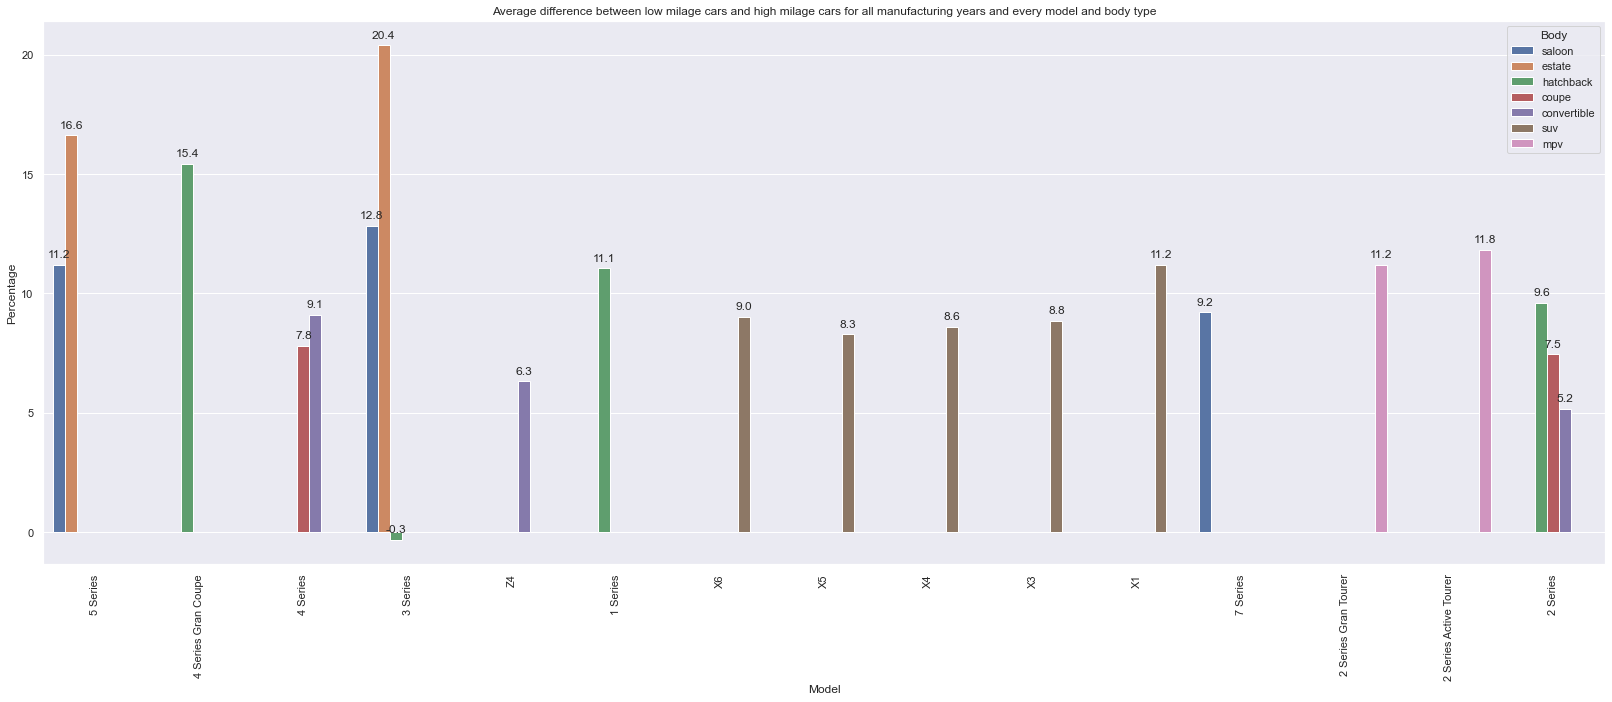

In [134]:
ax = sns.barplot(x = 'Model', y = 'Milage induced price difference', hue = 'Body', data = milage_depreciation_all_years)
sns.set(rc={'figure.figsize':(28,10)})
ax.set(title = 'Average difference between low milage cars and high milage cars for all manufacturing years and every model and body type', ylabel = 'Percentage')

for p in ax.patches:
    height = p.get_height()
    if pd.notna(height):
        ax.text(x = p.get_x()+(p.get_width()/2), y = height + 0.3, s = '{:.1f}'.format(height), ha = 'center')

locs, labels = plt.xticks()
plt.setp(labels, rotation=90);

Now lets have a look at the influence of engine size on age and milage depreciation

In [135]:
list_of_years = np.sort(df['year'].unique())
list_of_bodies = np.delete(df['body'].unique(),np.where(df['body'].unique()=='unlisted'))
list_of_engine_sizes = np.sort(np.delete(df['engine_size'].unique(), np.where(df['engine_size'].unique() == 50)))

age_depreciation_all_years_and_engines = pd.DataFrame(columns = ['Body', 'Engine size', 'Age depreciation'])

counter = 0

for body in list_of_bodies:
    for engine in list_of_engine_sizes:
        original_value = df.loc[(df['engine_size'] == engine) & (df['year'] == 2021) & (df['body'] == body)]['price'].mean()
        depreciated_value = df.loc[(df['engine_size'] == engine) & (df['year'] == 2015) & (df['body'] == body)]['price'].mean()
        if pd.notna(original_value) and pd.notna(depreciated_value):
            body_index = np.where(list_of_bodies == body)[0][0]
            depreciation_percentage = (original_value - depreciated_value) / original_value * 100
            age_depreciation_all_years_and_engines.loc[counter, 'Body'] = body
            age_depreciation_all_years_and_engines.loc[counter, 'Engine size'] = engine
            age_depreciation_all_years_and_engines.loc[counter, 'Age depreciation'] = depreciation_percentage
            counter += 1

age_depreciation_all_years_and_engines.head(20)

,Body,Engine size,Age depreciation
0,saloon,2.0,67.066274
1,saloon,3.0,66.709539
2,hatchback,1.5,63.155213
3,hatchback,2.0,63.082726
4,hatchback,3.0,61.42608
5,coupe,2.0,62.446896
6,coupe,3.0,54.064482
7,convertible,2.0,54.652562
8,convertible,3.0,57.095953
9,estate,2.0,69.302262


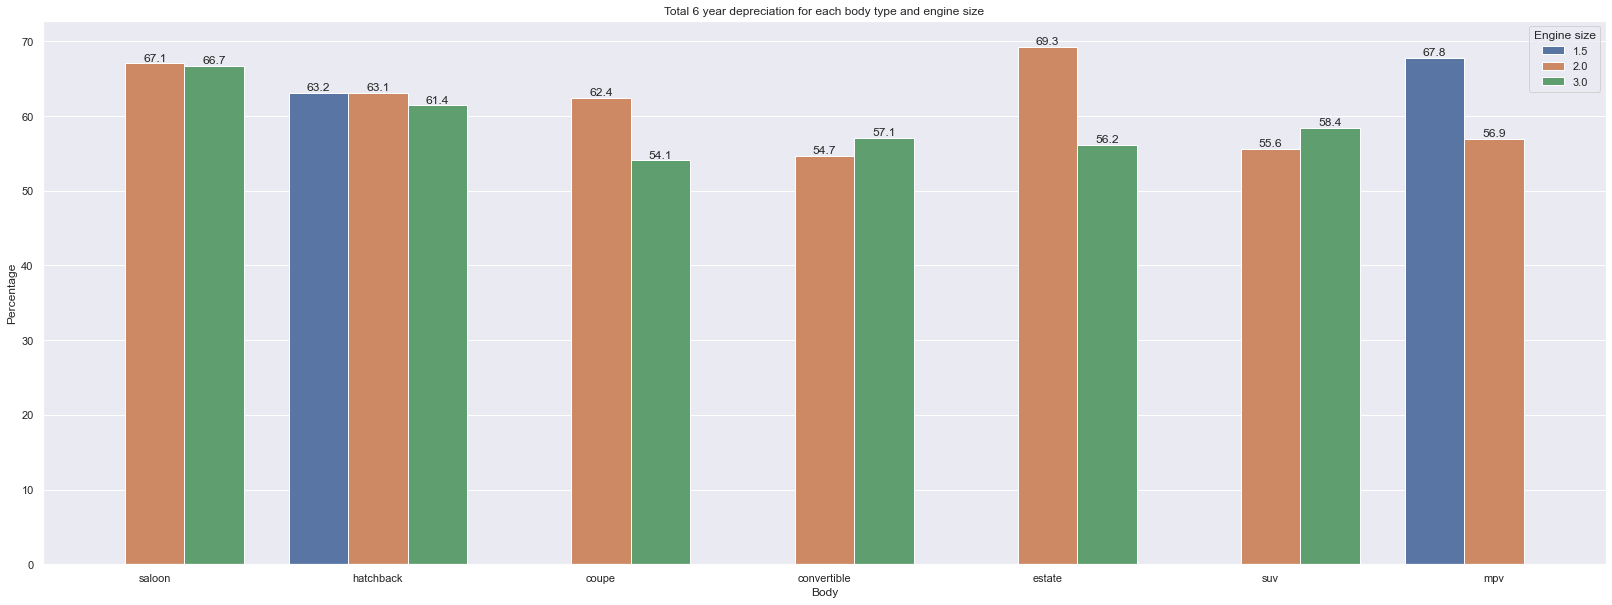

In [136]:
ax = sns.barplot(x = 'Body', y = 'Age depreciation', hue = 'Engine size', data = age_depreciation_all_years_and_engines)
sns.set(rc={'figure.figsize':(28,10)})
ax.set(title = 'Total 6 year depreciation for each body type and engine size', ylabel = 'Percentage')

for p in ax.patches:
    height = p.get_height()
    if pd.notna(height):
        ax.text(x = p.get_x()+(p.get_width()/2), y = height + 0.3, s = '{:.1f}'.format(height), ha = 'center')

In [137]:
list_of_years = np.sort(df['year'].unique())
list_of_bodies = np.delete(df['body'].unique(),np.where(df['body'].unique()=='unlisted'))
list_of_engine_sizes = np.sort(np.delete(df['engine_size'].unique(), np.where(df['engine_size'].unique() == 50)))

milage_depreciation_all_years = pd.DataFrame(columns = ['Body', 'Engine size', 'Milage induced price difference'])

counter = 0

for body in list_of_bodies:
    for engine in list_of_engine_sizes:
        acumulator = 0
        corrector = 0
        for year in list_of_years:
            filtered_df = df.loc[(df['engine_size'] == engine) & (df['year'] == year) & (df['body'] == body)]
            low_milage_mean = filtered_df.loc[filtered_df['milage'] < filtered_df['milage'].mean()]['price'].mean()
            high_milage_mean = filtered_df.loc[filtered_df['milage'] > filtered_df['milage'].mean()]['price'].mean()
            if pd.notna(low_milage_mean) and pd.notna(high_milage_mean):
                percentage_difference = (low_milage_mean - high_milage_mean) / low_milage_mean * 100
                acumulator += percentage_difference
            else:
                corrector += 1
        if (len(list_of_years) - corrector) > 0:
            percentage_difference = acumulator / (len(list_of_years) - corrector)
            milage_depreciation_all_years.loc[counter, 'Engine size'] = engine
            milage_depreciation_all_years.loc[counter, 'Body'] = body
            milage_depreciation_all_years.loc[counter, 'Milage induced price difference'] = percentage_difference
            counter += 1
        elif (len(list_of_years) - corrector) < 0:
            print('Acumulator: ', acumulator,', Corrector: ', corrector)
        else:
            pass

milage_depreciation_all_years.head(20)

,Body,Engine size,Milage induced price difference
0,saloon,1.5,16.626169
1,saloon,2.0,12.799262
2,saloon,3.0,7.917026
3,saloon,4.4,4.981429
4,hatchback,1.5,9.98836
5,hatchback,1.6,15.353306
6,hatchback,2.0,11.693621
7,hatchback,3.0,7.020508
8,coupe,1.5,8.464244
9,coupe,2.0,7.953808


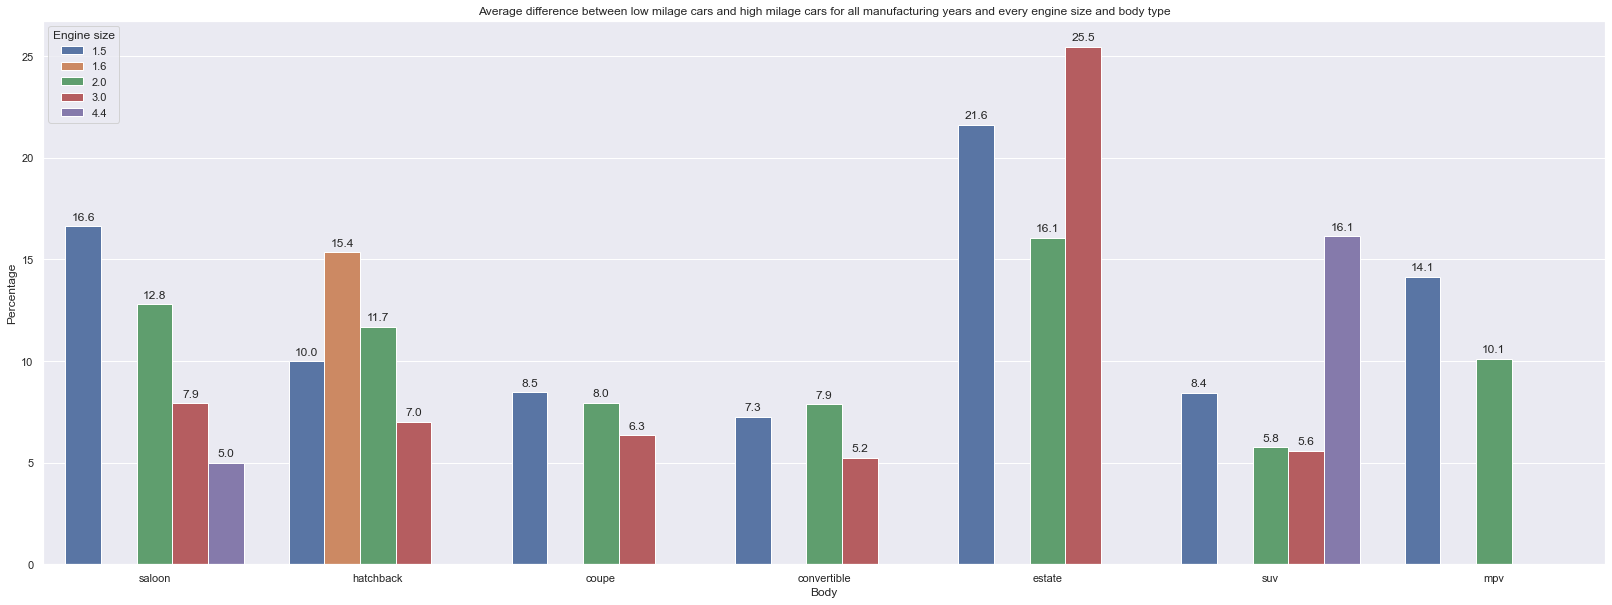

In [138]:
ax = sns.barplot(x = 'Body', y = 'Milage induced price difference', hue = 'Engine size', data = milage_depreciation_all_years)
sns.set(rc={'figure.figsize':(28,10)})
ax.set(title = 'Average difference between low milage cars and high milage cars for all manufacturing years and every engine size and body type', ylabel = 'Percentage')

for p in ax.patches:
    height = p.get_height()
    if pd.notna(height):
        ax.text(x = p.get_x()+(p.get_width()/2), y = height + 0.3, s = '{:.1f}'.format(height), ha = 'center')